In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
import matplotlib.pyplot as plt

import ssl

BATCH_SIZE = 4
EPOCHS = 5
MODEL_PATH = 'model/cifar10_pytorch.pth'
DEVICE = (
  "cuda"
  if torch.cuda.is_available()
  else "mps"
  if torch.backends.mps.is_available()
  else "cpu"
)

In [2]:
transform = v2.Compose([
  # v2.Resize(size=(IMAGE_HEIGHT, IMAGE_WIDTH)) CIFAR10 dataset is already resized to 32x32
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
ssl._create_default_https_context = ssl._create_unverified_context

#CIFAR10 of 32x32x3 image
trainset = CIFAR10('data', train=True, download=True, transform=transform)
testset = CIFAR10('data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:15<00:00, 10670621.92it/s]


Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [5]:
train_dataloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

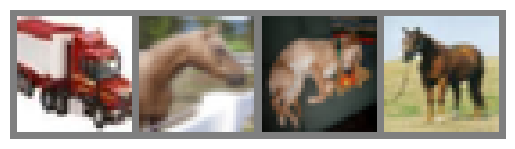

truck horse dog horse


In [6]:
def imshow(img):
  # img_f = (img_i - mean) / std
  # img_i = img_f * std + mean = (img_i / 2) + 0.5
  img = (img * 0.5) + 0.5
  transformed_img = img.numpy().transpose((1, 2, 0))
  plt.imshow(transformed_img)
  plt.axis('off')
  plt.show()

data_iterator = iter(train_dataloader)
X, y = next(data_iterator)

imshow(torchvision.utils.make_grid(X))
print(' '.join(f'{classes[y[j]]}' for j in range(BATCH_SIZE)))

In [7]:
class CIFAR_model(nn.Module):
  def __init__(self):
    super(CIFAR_model, self).__init__()
    # Original shape: 32x32x3
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5))
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5))
    self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)
  
  def forward(self, x):
    # Use functional API for stateless objects. Unnessecary to use nn.relu, but required if defined in __init__
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
model = CIFAR_model().to(DEVICE)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [9]:
for epoch in range(EPOCHS):
  mini_batch_loss = 0
  for i, (X, y) in enumerate(train_dataloader, start=0):
    X, y = X.to(DEVICE), y.to(DEVICE)
    optimizer.zero_grad()

    pred = model(X)
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()

    mini_batch_loss += loss.item()
    if i % 4000 == 3999:
      #For every 2000 iterations, print out the 2000 iteration's average loss
      print(f"[{epoch+1}, {i+1:5d}] -------- Mini-batch Loss {mini_batch_loss/2000:>.4f}")
      mini_batch_loss = 0
print("Training Finished")

[1,  4000] -------- Mini-batch Loss 4.0212
[1,  8000] -------- Mini-batch Loss 3.2542
[1, 12000] -------- Mini-batch Loss 3.0132
[2,  4000] -------- Mini-batch Loss 2.7879
[2,  8000] -------- Mini-batch Loss 2.6993
[2, 12000] -------- Mini-batch Loss 2.5964
[3,  4000] -------- Mini-batch Loss 2.4736
[3,  8000] -------- Mini-batch Loss 2.4149
[3, 12000] -------- Mini-batch Loss 2.3655
[4,  4000] -------- Mini-batch Loss 2.2417
[4,  8000] -------- Mini-batch Loss 2.2441
[4, 12000] -------- Mini-batch Loss 2.2373
[5,  4000] -------- Mini-batch Loss 2.0758
[5,  8000] -------- Mini-batch Loss 2.1125
[5, 12000] -------- Mini-batch Loss 2.1049
Training Finished


In [10]:
#Instead of saving the model directly, it is recommended by Pytorch to save only the state dict (for compatibility reasons)
#After saving, you can load it using load_state_dict
torch.save(model.state_dict(), MODEL_PATH)

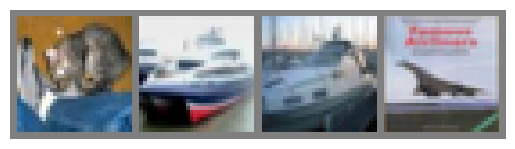

Ground Truth Label: cat ship ship airplane


In [11]:
data_iterator = iter(test_dataloader)
X, y = next(data_iterator)

imshow(torchvision.utils.make_grid(X))
print("Ground Truth Label:", ' '.join(f'{classes[y[j]]}' for j in range(BATCH_SIZE)))

In [12]:
model = CIFAR_model()
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [13]:
correct, total = 0, len(test_dataloader.dataset)
with torch.no_grad():
  for (X, y) in test_dataloader:
    X, y = X.to(DEVICE), y.to(DEVICE)

    outputs = model(X)
    # outputs shares the same data with outputs.data, but the .data attribute skips autograd backpropagation computation graph
    # Since the larger logits would have the larger probability, you do not need to pass in softmax layer
    pred_values, pred_index = torch.max(outputs.data, dim=1) #reduce/collapse dimension 1 (4 rows of batch and 10 columns of classses)

    correct += (pred_index == y).sum().item() 

print(f'Test Accuracy of size {total}: {(correct/total) * 100:.2f} %')

Test Accuracy of size 10000: 59.98 %


In [14]:
# From Pytorch Website and removed redundancy 